In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# generate signal
def generate_signal(omega, t, x0=np.float64(0)):
    
    # Get angle that should be swept
    angle_to_sweep = x0 + omega*t
    
    # Get the angle b/w limits
    normalized_angle = np.mod(angle_to_sweep, 2*np.pi)
    # Return answer
    if(np.allclose(normalized_angle, 2*np.pi, rtol=1e-5)):
        x = 0
    else:
        x = normalized_angle
    return x

In [3]:
def sample_signal(omega, Fs, tfinal):
    
    # Sample uniformly ts
    step = 1/Fs
    ts = np.arange(0, tfinal, step, dtype=np.float32)
    
    # Get xs for given ts
    xs = np.float32(generate_signal(omega, ts))
    
    return (xs, ts)


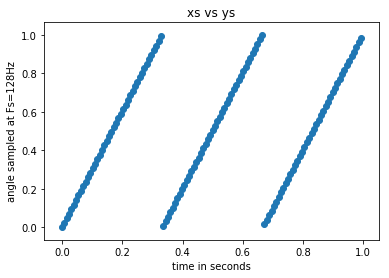

In [6]:
omega = 2*np.pi*(2+1)
Fs = 128
xs, ts = sample_signal(omega, Fs, 1)

xs /= np.max(xs)

plt.title('xs vs ys')
plt.xlabel('time in seconds')
plt.ylabel('angle sampled at Fs=128Hz')
plt.scatter(ts, xs)
plt.show()

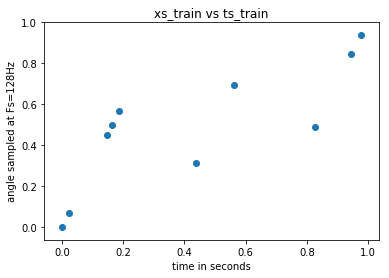

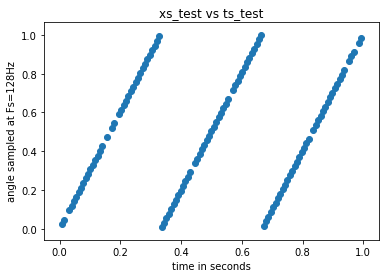

In [7]:
np.random.seed(1+2)
idx = np.sort(np.random.randint(len(xs), size=10))
xs_train = xs[idx]
ts_train = ts[idx]

xs_test =  np.delete(xs, idx)
ts_test =  np.delete(ts, idx)

plt.title('xs_train vs ts_train')
plt.xlabel('time in seconds')
plt.ylabel('angle sampled at Fs=128Hz')
plt.scatter(ts_train, xs_train)
plt.show()

plt.title('xs_test vs ts_test')
plt.xlabel('time in seconds')
plt.ylabel('angle sampled at Fs=128Hz')
plt.scatter(ts_test, xs_test)
plt.show()

In [38]:
def gradient_descent(order_of_model, data_xs_ts, learning_rate = 0.01, init_coefs = None, lambda_coefs=0):
    
    powers = np.arange(0, order_of_model+1, 1)
    
    #initialize weights
    if(init_coefs==None):
        init_coefs = np.random.rand(order_of_model+1)
    
    for i in range(10000):
        
        #define the input matrix
        
        phi = np.power(np.float32([data_xs_ts[1]]).T , powers)
        ys = np.matmul(phi, np.float32([init_coefs]).T)
        
        err = data_xs_ts[0] - np.ravel(ys)
        grad = -2*np.matmul(np.float32([err]), phi) + lambda_coefs*np.sign(init_coefs)
        
        if(np.allclose(grad, 1e-4)):
            return(init_coefs)
        init_coefs = init_coefs - np.ravel(grad)*learning_rate
    return(init_coefs)

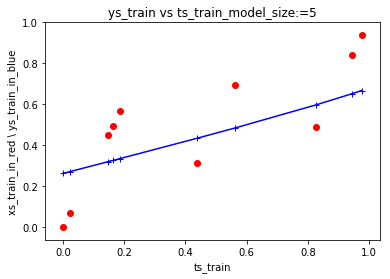

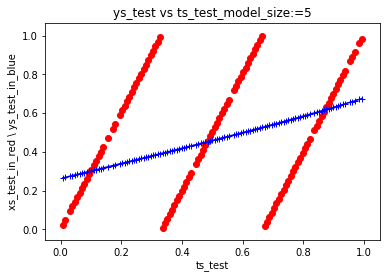

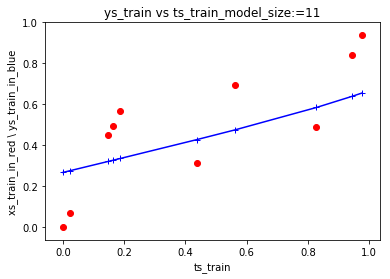

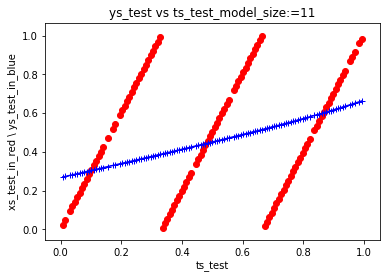

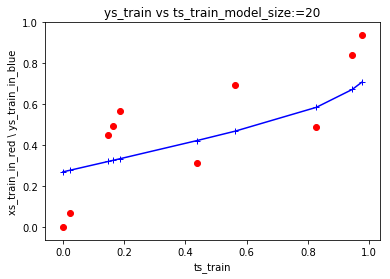

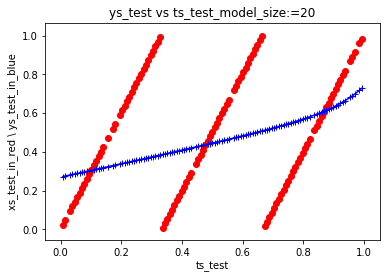

In [39]:
# with LASSO
for i in [5, 11, 20]:
    weights = gradient_descent(i, [xs_train, ts_train], lambda_coefs=1)
    
    ys_train = np.polynomial.polynomial.polyval(ts_train, np.ravel(weights))
#     print(ys_train-xs_train)
    plt.title('ys_train vs ts_train_model_size:='+str(i))
    plt.xlabel('ts_train')
    plt.ylabel('xs_train_in_red \\ ys_train_in_blue')
    plt.scatter(ts_train, xs_train, c='red', marker='o')
    plt.plot(ts_train, ys_train, c='blue', marker='+')
    plt.show()
    
    ys_test = np.polynomial.polynomial.polyval(ts_test, np.ravel(weights))
#     print(ys_train-xs_train)
    plt.title('ys_test vs ts_test_model_size:='+str(i))
    plt.xlabel('ts_test')
    plt.ylabel('xs_test_in_red \\ ys_test_in_blue')
    plt.scatter(ts_test, xs_test, c='red', marker='o')
    plt.plot(ts_test, ys_test, c='blue', marker='+')
    plt.show()

In [41]:
Ed_train = []
Ed_test = []
we= []
for i in np.arange(0, 1, 0.01):
    print(i)
    weights = gradient_descent(10, [xs_train, ts_train], lambda_coefs=i)
    we.append(weights)
    w = np.sort(abs(weights))[:math.floor(len(weights)/2)]
    print(w)
    ys_train = np.polynomial.polynomial.polyval(ts_train, np.ravel(weights))
    err = np.sum(np.square(xs_train-ys_train))
    Ed_train.append([err, i])
    
    ys_test = np.polynomial.polynomial.polyval(ts_test, np.ravel(weights))
    err = np.sum(np.square(xs_test-ys_test))
    Ed_test.append([err, i])
    
    if len(np.where(abs(weights)<1e-3)[0])==math.ceil(len(weights)/2):
        break

0.0
[0.05529978 0.1071637  0.15816316 0.28335802 0.29618872]
0.01
[5.88225548e-05 1.03459288e-04 1.27216894e-04 6.68519928e-04
 9.26430016e-02]
0.02
[4.27273341e-05 6.20299807e-05 1.10391475e-04 1.63507159e-04
 1.97408164e-04]
0.03
[4.29105386e-07 7.42002556e-06 1.00507532e-04 1.72152362e-04
 3.49956460e-04]
0.04
[3.35370261e-05 5.38190856e-05 2.45346253e-04 2.71968715e-04
 3.39838731e-04]


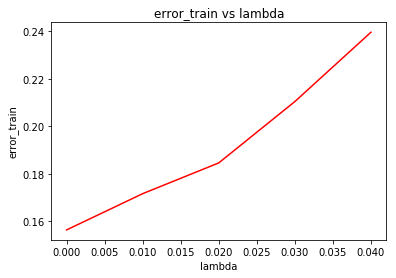

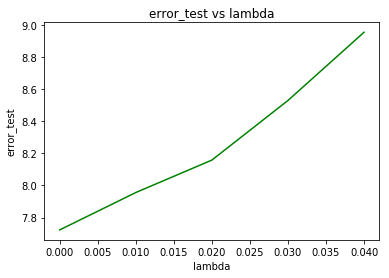

In [42]:
plt.plot(np.float32(Ed_train)[:, 1], np.float32(Ed_train)[:, 0], c='red')
plt.title('error_train vs lambda')
plt.xlabel('lambda')
plt.ylabel('error_train')
plt.show()

plt.plot(np.float32(Ed_test)[:, 1], np.float32(Ed_test)[:, 0], c='green')
plt.title('error_test vs lambda')
plt.xlabel('lambda')
plt.ylabel('error_test')
plt.show()

In [43]:
we = np.float32(we)
for i in range(len(we[0, :])):
    plt.plot(np.arange(len(we[:, i])), we[:, i])
    plt.xlabel('lambda')
    plt.ylabel('final weights')
    plt.title('weights vs lambda')
plt.show()

## Taking values of weights<0.001 as zero

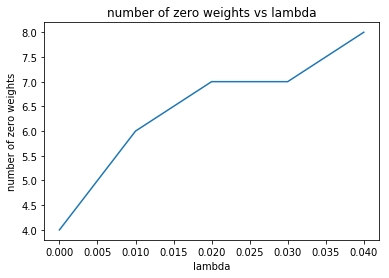

In [44]:
idx_plot = []
j = np.arange(0, 1, 0.01)
for i in range(len(we)):
    idx = np.where(we[i, :]<0.001)[0]
    idx_plot.append([len(idx), j[i]])
idx_plot = np.float32(idx_plot)
plt.plot(idx_plot[:, 1], idx_plot[:, 0])
plt.xlabel('lambda')
plt.ylabel('number of zero weights')
plt.title('number of zero weights vs lambda')
plt.show()

## exactly half weights <= 0.001

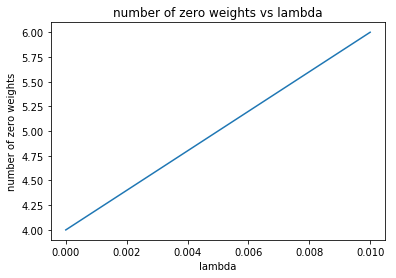

In [45]:
idx_plot = []
for i in range(len(we)):
    idx = np.where(we[i, :]<0.001)[0]
    idx_plot.append([len(idx), j[i]])
    if(len(idx)>=5):
        break
idx_plot = np.float32(idx_plot)
plt.plot(idx_plot[:, 1], idx_plot[:, 0])
plt.xlabel('lambda')
plt.ylabel('number of zero weights')
plt.title('number of zero weights vs lambda')
plt.show()